In [25]:
from division_aware import *
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import  LineString

In [120]:
def edges_geoms(graph, shp, key = "GEOID10"):
    key_dict = {}
    for _idx, row in shp.iterrows():
        key_dict[row[key]] = row['geometry']
    edges = list(graph.edges)
    nodes = [((graph.nodes[u]), (graph.nodes[v])) for u,v in edges]
    keys = [(n1[key], n2[key]) for n1, n2 in nodes]
    geoms = [(key_dict[k1], key_dict[k2]) for k1,k2 in keys]
    return geoms

def edges_to_gdf(graph, shp, key = "GEOID10"):
    dual = gpd.GeoDataFrame(gpd.GeoSeries([LineString([poly1.centroid, poly2.centroid]) for poly1,poly2 in edges_geoms(graph, shp, key = key)]), columns = ['geometry'])
    return dual.set_crs(shp.crs)

def division_random_spanning_tree(graph, division_tuples=[("COUNTYFP", 1)]):
    """
    Generates a spanning tree that discourages edges that cross divisions (counties, municipalities, etc).
    We probabilistically assign weights to every edge, and then draw a minumum spanning
    tree over the graph. This means that edges with lower weights will be preferred as the tree is drawn.

    Parameters:
    ----------
    graph: GerryChain Graph object
        The region upon which to draw the spanning tree (usually two districts merged together)
    division_tuples: list of (str, float)
        A list of tuples where the first element is the division column and the second element is
        the weight penalty added to any edge that spans two divisions of that type.
    """
    weights = {edge:1 for edge in graph.edges}
    for edge in graph.edges:
        for (division_col, penalty) in division_tuples:
            if graph.nodes[edge[0]][division_col] != graph.nodes[edge[1]][division_col]:
                weights[edge] += penalty
        graph.edges[edge]["weight"] = weights[edge] + random.random()

    spanning_tree = tree.minimum_spanning_tree(
        graph, algorithm="kruskal", weight="weight"
    )
    return spanning_tree

In [50]:
%%time
shp = gpd.read_file("shapes/WI_2020_wards/")
graph = Graph.from_file("shapes/WI_2020_wards/")

/Users/gabe/miniconda3/envs/gerrychain/lib/python3.8/site-packages/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1518, 63}
  warnings.warn(
/Users/gabe/miniconda3/envs/gerrychain/lib/python3.8/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column Code!
  warnings.warn("NA values found in column {}!".format(column))


CPU times: user 37.4 s, sys: 559 ms, total: 38 s
Wall time: 38.1 s


In [75]:
%%time
focus_shp = shp[(shp["HDIST"] == "74") | (shp["HDIST"] == "87")]
focus_shp.to_file("shapes/WI_focus")
focus_graph = Graph.from_file("shapes/WI_focus")

edges = edges_to_gdf(focus_graph, focus_shp, key="Code-2")

part = Partition(focus_graph, "HDIST", {})

/Users/gabe/miniconda3/envs/gerrychain/lib/python3.8/site-packages/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {20}
  warnings.warn(


CPU times: user 2.56 s, sys: 47.4 ms, total: 2.61 s
Wall time: 2.61 s


In [102]:
full_partition = Partition(graph, "HDIST", {})

In [124]:
# tree_edges = edges_to_gdf(nx.minimum_spanning_tree(focus_graph), focus_shp, key="Code-2")
aware_edges = edges_to_gdf(division_random_spanning_tree(focus_graph), focus_shp, key="Code-2")

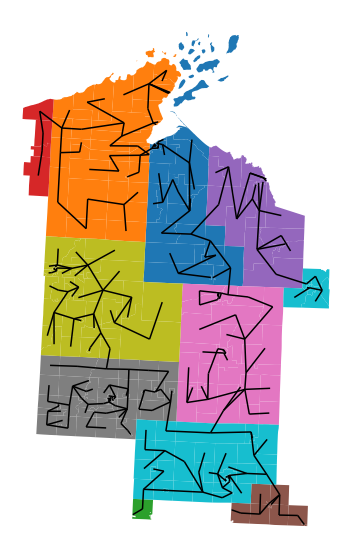

In [127]:
fig, ax = plt.subplots(figsize=(10,10))

# shp.plot(ax=ax, column=shp["HDIST"])
# part.plot(ax=ax)
focus_shp.plot(ax=ax, column=focus_shp["COUNTYFP"])
# tree_edges.plot(ax=ax, color="black")
aware_edges.plot(ax=ax, color="black")
plt.axis('off')
plt.savefig("presentation/aware_edges_with_counties", dpi=600, bbox_inches='tight')

<AxesSubplot:>

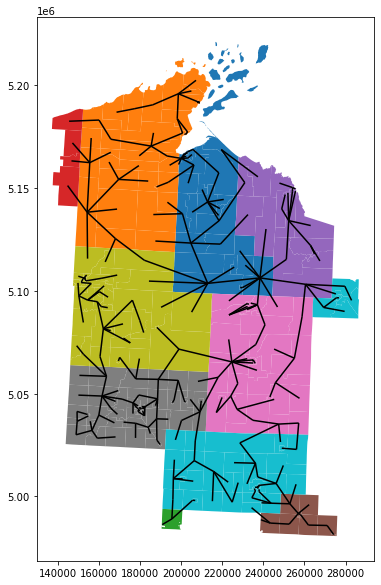

In [91]:
fig, ax = plt.subplots(figsize=(10,10))

# part.plot(ax=ax)
focus_shp.plot(ax=ax, column=focus_shp["COUNTYFP"])
tree_edges.plot(ax=ax, color="black")

In [9]:
part = Partition(graph, "HDIST", updaters={})

<AxesSubplot:>

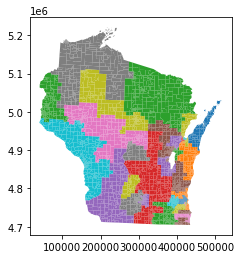

In [10]:
part.plot()

<AxesSubplot:>

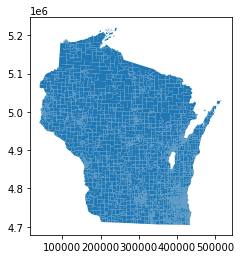

In [5]:
shp.plot()